# Writeup 
I have found that about 18% of users are "adopted users". I have investigated the features and concluded the following: 
 * **Numerical features**: 
   - 'last_session_creation_time': This is not predictive
   - 'opted_in_to_mailing_list': Tiny difference in this feature between adopted users and not: 
      - non adopted user opt in rate: 0.250935
      - adopted user opt in rate: 0.258427
   - 'enabled_for_marketing_drip': Similar to last feature, little difference
   - 'org_id': different org ids have different target rates. This could be useful
   - 'invited_by_user_id': 
    
        
        
  * **Non-numerical features**
      * 'creation_time': Can't find much of a relationship in any weekly, daily, or time relationship. 
      But There is a relationship with month it seems. users with creation_time in april or may have low adoption rates, but june has exceptionally high adoption rates. This may be due to some special feature of the software use cases.
      * 'name': Didn't investigate
      * 'email': grouping by the domain name gives so decent info
        - **domain, count, target_mean**
        - gmail	2930	0.185324
        - yahoo	1726	0.151217
        - jourrapide	883	0.184598
        - gustr	842	0.169834
        - cuvox	828	0.166667
        - hotmail	803	0.245330
      * 'creation_source'
         - **creation_source, target_mean**
         - GUEST_INVITE          0.226700
         - ORG_INVITE            0.173463
         - PERSONAL_PROJECTS     0.214660
         - SIGNUP                0.154373
         - SIGNUP_GOOGLE_AUTH    0.167509
      * 'invited_others
        - target_mean by invited_others	
        - False	0.171234
        - True	0.227050

In [86]:
use_cols = ['creation_source', 'org_id', 'invited_others', 'domain', 'month']

# Investigation

In [1]:
import itertools
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
eng = pd.read_csv('takehome_user_engagement.csv')
usr = pd.read_csv('takehome_users.csv', encoding='cp1252')

In [3]:
display(eng.head(6))
display(eng.info())
display(eng.visited.value_counts())


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


None

1    207917
Name: visited, dtype: int64

In [4]:
eng['date'] =( pd.to_datetime(eng['time_stamp']) - pd.to_datetime(eng['time_stamp']).min()).dt.days

In [5]:
eng = eng.sort_values('date')

In [7]:
def min_day_change_for_3_visits(df): 
    return (df.date - df.date.shift(2)).min() <= 6

In [8]:
target = eng.groupby('user_id').apply(min_day_change_for_3_visits).rename('target').astype(int)
usr = usr.merge(target, left_on='object_id', right_index=True)
usr.isna().sum()
print(target.mean())

0.18157089425365522


In [9]:
usr.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,target
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [17]:
usr.select_dtypes('number').columns.tolist()

['object_id',
 'last_session_creation_time',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'org_id',
 'invited_by_user_id',
 'target']

In [10]:
usr.select_dtypes('number').describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,target
count,8823.000000,8.823000e+03,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000
mean,6019.821716,1.379279e+09,0.252295,0.151989,142.572254,5980.495394,0.181571
std,3464.251001,1.953116e+07,0.434354,0.359031,124.176422,3394.211361,0.385512
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3017.500000,1.363195e+09,0.000000,0.000000,30.000000,3071.000000,0.000000
50%,6034.000000,1.382888e+09,0.000000,0.000000,109.000000,5947.000000,0.000000
75%,9029.500000,1.398443e+09,1.000000,0.000000,239.000000,8857.250000,0.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


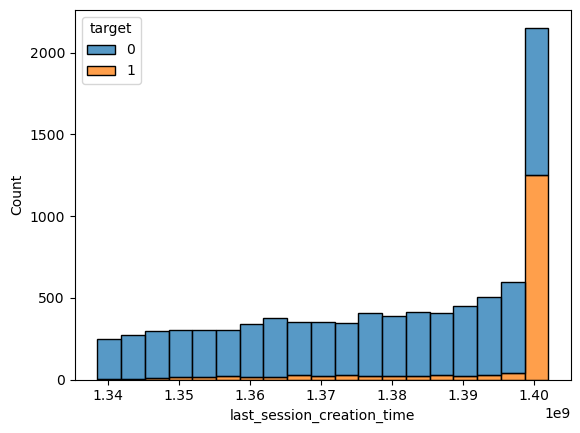

In [15]:
sns.histplot(data=usr, x='last_session_creation_time', hue='target', multiple='stack');

In [19]:
usr.groupby('target')['opted_in_to_mailing_list'].mean()

target
0    0.250935
1    0.258427
Name: opted_in_to_mailing_list, dtype: float64

In [20]:
usr.groupby('target')['enabled_for_marketing_drip'].mean()

target
0    0.151641
1    0.153558
Name: enabled_for_marketing_drip, dtype: float64

<Axes: >

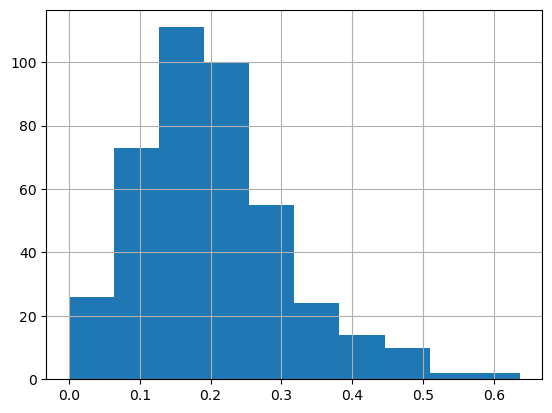

In [22]:
usr.groupby('org_id').target.mean().hist()

In [23]:
usr.groupby(usr.invited_by_user_id.isna()).target.mean()

invited_by_user_id
False    0.191164
True     0.170250
Name: target, dtype: float64

In [25]:
invited_others = set(usr.invited_by_user_id)

In [27]:
usr['invited_others'] = usr.object_id.isin(invited_others)

In [29]:
usr.groupby('invited_others').target.mean().rename('target_mean').to_frame()

,target_mean
invited_others,
False,0.171234
True,0.227050


## Object columns

In [32]:
usr.select_dtypes(exclude=['number']).columns.tolist()

['creation_time', 'name', 'email', 'creation_source', 'invited_others']

In [30]:
usr.select_dtypes(exclude=['number']).describe()

,creation_time,name,email,creation_source,invited_others
count,8823,8823,8823,8823,8823
unique,8821,8453,8810,5,2
top,2014-02-11 17:57:53,Correia Leonardo,MarkoSeiler@yahoo.com,ORG_INVITE,False
freq,2,4,2,3188,7189


In [37]:
usr['date'] = pd.to_datetime(usr['creation_time'])

Text(0.5, 1.0, 'day of week target mean')

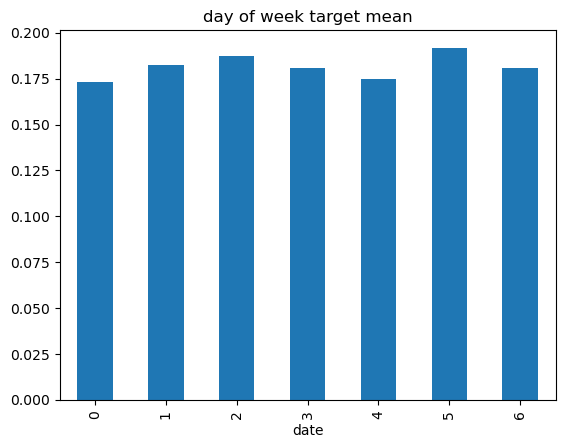

In [51]:
(usr.groupby(usr.date.dt.day_of_week).target.mean()).plot(kind='bar')
plt.title('day of week target mean')

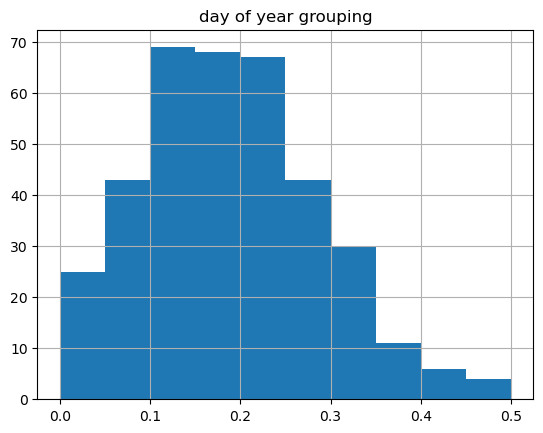

In [46]:
(usr.groupby(usr.date.dt.day_of_year).target.mean()).hist()
plt.title('day of year target grouping');

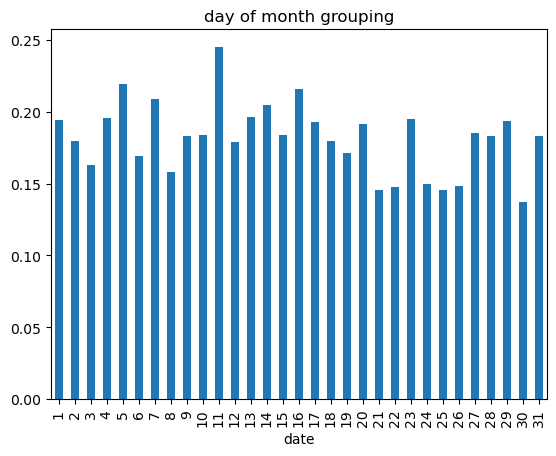

In [52]:
(usr.groupby(usr.date.dt.day).target.mean()).plot(kind='bar')
plt.title('day of month grouping');

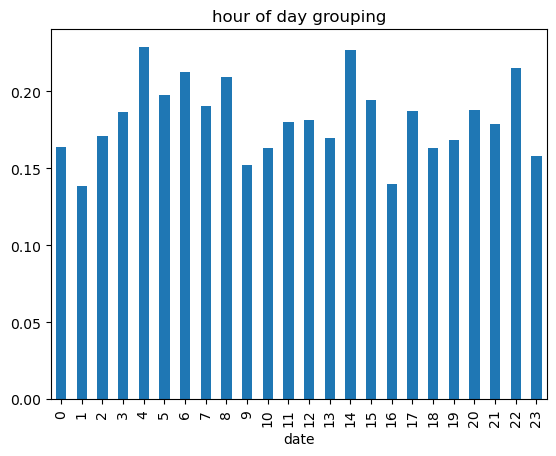

In [54]:
(usr.groupby(usr.date.dt.hour).target.mean()).plot(kind='bar')
plt.title('hour of day grouping');

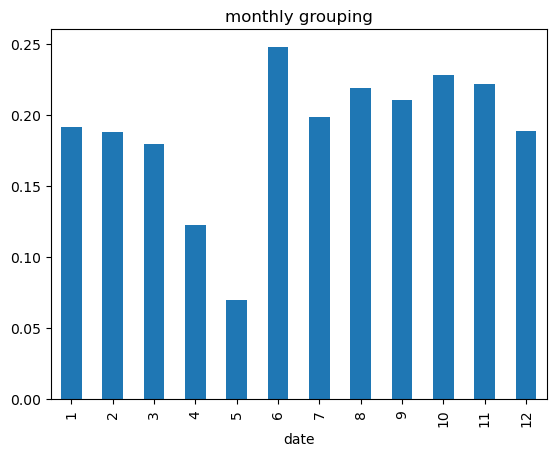

In [56]:
(usr.groupby(usr.date.dt.month).target.mean()).plot(kind='bar')
plt.title('monthly grouping');

In [83]:
usr['month'] = usr.date.dt.month

In [68]:
usr['domain'] = usr.email.str.split('@').str[-1].str.split('.').str[0]

<Axes: >

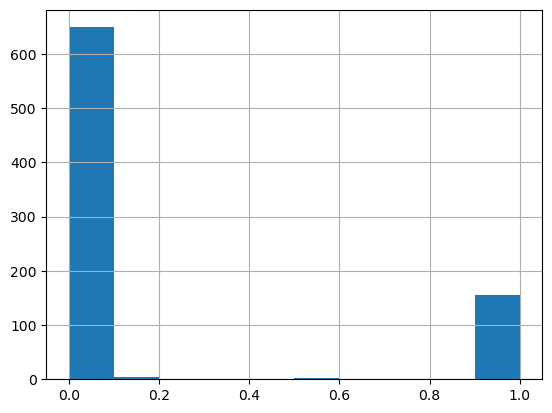

In [70]:
usr.groupby('domain').target.mean().hist()

<Axes: >

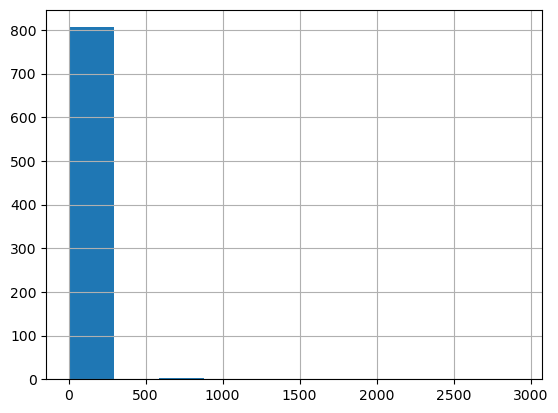

In [72]:
usr.domain.value_counts().hist()

In [79]:
pd.concat((usr.domain.value_counts(), usr.groupby('domain').target.mean()), axis=1).head(20)

,domain,target
gmail,2930,0.185324
yahoo,1726,0.151217
jourrapide,883,0.184598
gustr,842,0.169834
cuvox,828,0.166667
hotmail,803,0.245330
luque,2,0.500000
mumdc,2,0.500000
oqpze,2,0.000000
xybhi,2,0.000000


In [81]:
usr.groupby('creation_source').target.mean()

creation_source
GUEST_INVITE          0.226700
ORG_INVITE            0.173463
PERSONAL_PROJECTS     0.214660
SIGNUP                0.154373
SIGNUP_GOOGLE_AUTH    0.167509
Name: target, dtype: float64